The Telecommunication industry has experienced a great revolution since the last decade. Mobile devices have become the new fashion trend and play a vital role in everyone's life. The success of the mobile industry is largely dependent on its consumers. Therefore, it is necessary for the vendors to focus on their target audience i.e. what are the needs and requirements of their consumers and how they feel and perceive their products. Tracking & evaluating of customers’ experience can help organizations to optimize their products and services so that it meets the evolving user expectations, needs, and acceptance.

In the telecommunication industry, the user experience is related, most of the time, to network parameter performances or the customers’ device characteristics.  

In this section, you’re expected to focus on network parameters like TCP retransmission, Round Trip Time (RTT), Throughput, and the customers’ device characteristics like the handset type to conduct a deep user experience analysis. The network parameters are all columns in the dataset. The following questions are your guidance to complete the task. For this task, you need a python script that includes all solutions to tasks.

Task 3. 1 - Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable):
●	Average TCP retransmission
●	Average RTT
●	Handset type
●	Average throughput
Task 3.2 - Compute & list 10 of the top, bottom, and most frequent:
a.	TCP values in the dataset. 
b.	RTT values in the dataset.
c.	Throughput values in the dataset.
Task 3.3 - Compute & report:
d.	The distribution of the average throughput per handset type and provide interpretation for your findings.
e.	The average TCP retransmission view per handset type and provide interpretation for your findings.
Task 3.4 - Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [ ]:
base_path = os.getcwd().split("src")[0]
sys.path.append(base_path)

from src.scripts.utils import set_path

In [2]:
path = set_path("data")


>> set up path to the data directory


In [3]:
data = pd.read_csv(path + "telco.csv").iloc[:-1]

In [4]:
desc = pd.read_excel(path + "field_descriptions.xlsx").set_index("Fields")

In [5]:
def resolve_outlier_iqr(df):
    data = df.copy()
    for i in data.select_dtypes(["int", "float"]).keys():
        Q1,Q3 = data[i].quantile([.20,.80])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        lr_ind = data[i][data[i] < lower_range].keys()
        ur_ind = data[i][data[i] > upper_range].keys()

        data.loc[lr_ind, i] = np.nan
        data.loc[ur_ind, i] = np.nan
        data[i].fillna(data[i].mean(), inplace= True)
    return data

In [6]:
def resolve_outlier(df):
    ## using z-score, then iqr
    data = df.copy()
    for i in data.select_dtypes(["int", "float"]).keys():
        outliers = data[i][(abs((data[i] - data[i].mean()) / data[i].std()) > 3)].keys()
        data.loc[outliers, i] = np.nan
        data[i].fillna(data[i].mean(), inplace= True)
    ## iqr
    data = resolve_outlier_iqr(data)
    return data

In [7]:
data.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [8]:
network_stats_cols = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 
                      'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'Handset Manufacturer', 
                      'Handset Type',
                     ]

In [9]:
ux_data = data[network_stats_cols]

In [10]:
# throughput of zero means the user was not online, the user will also have RTT and tcp retrans. of 0 (NaN)
# and it is clear from the description below
# I'll be dropping those entries.

invalid_entries = ux_data[(ux_data["Avg Bearer TP UL (kbps)"] == 0) | (ux_data["Avg Bearer TP DL (kbps)"] == 0)].index

#### Handling missing values

In [11]:
# there is no entry with 0 byte in the tcp retrans columns, It can be assumed that the NaN values represents 0 byte
ux_data[['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']] = \
    ux_data[['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']].fillna(0)

C:\Users\abola\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
ux_data = resolve_outlier(ux_data)

In [13]:
ux_data.describe()#[['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]

,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000
mean,55.895825,8.940721,9155.480850,429.499021,9.230659e+04,2619.771092
std,25.875549,7.236131,15089.256876,639.850324,2.474740e+05,6266.348105
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,35.000000,3.000000,43.000000,47.000000,0.000000e+00,0.000000
50%,54.000000,7.000000,63.000000,63.000000,0.000000e+00,0.000000
75%,80.915788,13.044177,11830.250000,465.000000,9.230659e+04,2619.771092
max,154.000000,34.000000,60504.000000,3200.000000,1.617030e+06,37367.000000


### Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable): ● Average TCP retransmission ● Average RTT ● Handset type ● Average throughput 

In [14]:
def sum_ul_dl(df):
    data = df.copy()
    summed_data = data.select_dtypes(exclude= ["int", "float"]).copy()
    count = 0
    for i,j in enumerate(data.select_dtypes(["int", "float"]).columns):
        if count != 1:
            summed_data[j.replace("UL", "Data").replace("DL", "Data")] = data.iloc[:, i] + data.iloc[:,i+1]
            count = (count + 1) % 2
        else: 
            count = (count + 1) % 2
            continue
    return summed_data

In [15]:
ux_data = sum_ul_dl(ux_data)

In [16]:
ux_data.describe()

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (Bytes)
count,150000.000000,150000.000000,1.500000e+05
mean,64.836546,9584.979871,9.492636e+04
std,29.521795,15474.470706,2.495763e+05
min,0.000000,0.000000,0.000000e+00
25%,40.000000,90.000000,0.000000e+00
50%,60.895825,125.000000,0.000000e+00
75%,93.959964,13237.276640,9.492636e+04
max,188.000000,63583.000000,1.648110e+06


In [17]:
# 	Avg RTT DL (ms)	Avg RTT UL (ms)	Avg Bearer TP DL (kbps)	Avg Bearer TP UL (kbps)	TCP DL Retrans. Vol (Bytes)	TCP UL Retrans. Vol (Bytes)
# count	150000.000000	150000.000000	150000.000000	150000.000000	1.500000e+05	150000.000000
# mean	47.250673	7.887062	7425.817491	366.371568	1.311051e+06	33719.823910
# std	19.277858	6.952875	12450.903656	552.806965	1.214180e+06	24363.747133
# min	0.000000	0.000000	0.000000	0.000000	2.000000e+00	1.000000
# 25%	35.000000	3.000000	43.000000	47.000000	1.311051e+06	33719.823910
# 50%	47.250673	7.000000	63.000000	63.000000	1.311051e+06	33719.823910
# 75%	51.000000	7.887062	7425.817491	366.371568	1.311051e+06	33719.823910
# max	127.000000	34.000000	49211.000000	2729.000000	9.365124e+06	203003.000000

In [18]:
#convert throughput to MB
ux_data["TCP Data Retrans. Vol (Bytes)"] /= 2**20
ux_data.rename(columns= {"TCP Data Retrans. Vol (Bytes)": "TCP Data Retrans. Vol (MBs)"}, inplace= True)

In [19]:
ux_data['MSISDN/Number'] = data['MSISDN/Number']

In [20]:
ux_data_per_user = ux_data.groupby('MSISDN/Number').mean()

handset_data = ux_data.groupby('MSISDN/Number')[['Handset Manufacturer', 'Handset Type']].agg(lambda x: pd.Series.mode(x)[0])

# ux_data_per_user[['Handset Manufacturer', 'Handset Type']] = handset_data

ux_data_per_user = handset_data.merge(ux_data_per_user, left_index= True, right_index= True)

del handset_data

In [21]:
# a user with no throughput means the user wasn't online throughout the month and I believe the entries are not useful for this analysis
invalid_entries_ind = (ux_data_per_user["Avg Bearer TP Data (kbps)"][ux_data_per_user["Avg Bearer TP Data (kbps)"] == 0]).keys()
ux_data_per_user = ux_data_per_user.drop(index= invalid_entries_ind)

### Compute & list 10 of the top, bottom, and most frequent: a. TCP values in the dataset. b. RTT values in the dataset. c. Throughput values in the dataset. 

In [22]:
def sort_each_col(df, aggregate, size= 10):
    data = df.copy()
    sorted_data = pd.DataFrame()
    if aggregate == "min":
        for i in data.select_dtypes(["int", "float"]).columns:
            sorted_data[i] = data[i].sort_values(ascending= True).unique()[:size]
            
    elif aggregate == "max":
        for i in data.select_dtypes(["int", "float"]).columns:
            sorted_data[i] = data[i].sort_values(ascending= False).unique()[:size]
            
    elif aggregate == "freq":
        for i in data.select_dtypes(["int", "float"]).columns:
            sorted_data[i] = data[i].value_counts().keys()[:size]
    
    else:
        raise Exception(f"aggregate unknown - {aggregate}\nValid - min, max, freq")
        
    return sorted_data

In [23]:
sort_each_col(ux_data_per_user, "freq")

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
0,93.959964,15.0,0.000000
1,29.000000,63.0,0.090529
2,39.000000,97.0,0.045264
3,38.000000,90.0,0.001234
4,40.000000,98.0,0.001268
5,30.000000,96.0,0.088030
6,28.000000,99.0,0.030176
7,49.000000,89.0,0.002537
8,41.000000,91.0,0.001257
9,31.000000,95.0,0.003805


In [24]:
sort_each_col(ux_data_per_user, "min")

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
0,0.000000,0.500000,0.000000
1,2.000000,1.000000,0.000002
2,4.000000,2.000000,0.000003
3,5.000000,3.000000,0.000004
4,6.000000,3.500000,0.000005
5,8.000000,3.666667,0.000005
6,8.940721,4.000000,0.000006
7,9.000000,5.000000,0.000008
8,10.000000,6.000000,0.000008
9,11.000000,6.333333,0.000009


In [25]:
sort_each_col(ux_data_per_user, "max")

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
0,185.0,63188.0,1.569390
1,184.0,63022.0,1.564180
2,183.0,63002.0,1.560955
3,182.0,63001.0,1.558649
4,181.0,62838.0,1.557378
5,180.0,62823.0,1.550790
6,179.0,62754.0,1.549342
7,178.0,62735.0,1.549082
8,177.0,62653.0,1.549008
9,176.0,62636.0,1.548539


### Task 3.3 - Compute & report: d. The distribution of the average throughput per handset type and provide interpretation for your findings. e. The average TCP retransmission view per handset type and provide interpretation for your findings.

In [26]:
ux_data_per_user.groupby(['Handset Type'])['Avg Bearer TP Data (kbps)'].mean().sort_values(ascending= False).to_frame()

,Avg Bearer TP Data (kbps)
Handset Type,
Huawei P9 Plus,56918.000000
A-Link Telecom I. Cubot Nova,56217.000000
Tecno Telecom (H. Phantom6 Plus,54197.000000
Oppo Cph1877,53593.023200
Huawei E8372,53164.499021
...,...
Concox Informati. Concox Gt06 Gt06N Tr06,2.000000
Test IMEI,2.000000
Quectel Wireless. Quectel Ec21-E,2.000000


In [27]:
ux_data_per_user.groupby(['Handset Type'])['TCP Data Retrans. Vol (MBs)'].mean().sort_values(ascending= False).to_frame()

,TCP Data Retrans. Vol (MBs)
Handset Type,
Lg-As330,1.529593
Blu Products Inc Blu R1 Plus,1.487554
Kenxinda V7,1.473402
Huawei Y6 Pro,1.473201
Lg Lg-D620Fr,1.413949
...,...
Quectel Wireless. Quectel Ec21-E,0.000000
Qingdao Hisense. Staraddict 6,0.000000
Qingdao Hisense. S41,0.000000


#### interpret your findings

### Task 3.4 - Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)

In [28]:
sub_ux_data = ux_data_per_user[['Avg RTT Data (ms)', 'Avg Bearer TP Data (kbps)', 
                       'TCP Data Retrans. Vol (MBs)'
                      ]].copy()

In [29]:
scaler = MinMaxScaler()
sub_ux_data_scaled = pd.DataFrame(scaler.fit_transform(sub_ux_data), columns= sub_ux_data.columns)

In [30]:
sub_ux_data_scaled.describe().style

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
count,106748.000000,106748.000000,106748.000000
mean,0.346343,0.134382,0.052556
std,0.151733,0.214546,0.133331
min,0.000000,0.000000,0.000000
25%,0.216216,0.001456,0.000000
50%,0.327027,0.003395,0.000000
75%,0.507653,0.196361,0.056092
max,1.000000,1.000000,1.000000


In [31]:
kmeans = KMeans(3, random_state=0)

In [32]:
kmeans.fit(sub_ux_data_scaled)

KMeans(n_clusters=3, random_state=0)

In [33]:
task3_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = sub_ux_data.columns)

In [34]:
mapper = dict(zip(task3_cluster_centers["Avg Bearer TP Data (kbps)"].sort_values().keys(), ["bad experience", "average experience", "good experience"]))

In [35]:
task3_cluster_centers = task3_cluster_centers.rename(index = mapper).rename_axis("labels")
task3_cluster_centers.to_csv(path + "user_experience_cluster_centers.csv")

In [36]:
sub_ux_data["labels"] = kmeans.labels_.copy()
sub_ux_data["labels"] = sub_ux_data["labels"].map(mapper)

In [37]:
sub_ux_data.groupby("labels").count()

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
labels,,,
average experience,52241,52241,52241
bad experience,33733,33733,33733
good experience,20774,20774,20774


In [48]:
sub_ux_data.groupby("labels").min()

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
labels,,,
average experience,0.000000,1.0,0.0
bad experience,64.836546,0.5,0.0
good experience,17.500000,284.0,0.0


In [39]:
sub_ux_data.to_csv(path + "user_experience_data.csv")

In [40]:
sub_ux_data.to_csv("user_engagement_data.csv")

In [41]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(sub_ux_data_scaled)
    sse.append(kmeans.inertia_)

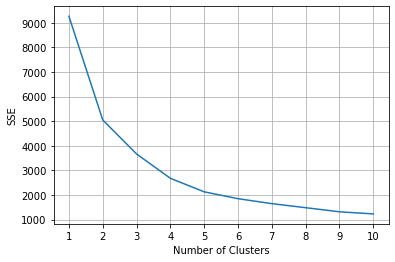

In [42]:
# plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(True)
#plt.show()

In [43]:
kmeans

KMeans(init='random', n_clusters=10, random_state=42)

#### provide a brief description of each cluster

In [44]:
sub_ux_data.describe()

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
count,106748.000000,106748.000000,106748.000000
mean,64.073456,8491.751034,0.082481
std,28.070672,13556.597472,0.209249
min,0.000000,0.500000,0.000000
25%,40.000000,92.500000,0.000000
50%,60.500000,215.000000,0.000000
75%,93.915788,12408.081920,0.088030
max,185.000000,63188.000000,1.569390


In [45]:
sub_ux_data.sort_values(["Avg Bearer TP Data (kbps)"]).head(20)

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs),labels
MSISDN/Number,,,,
3.361619e+10,93.959964,0.5,0.000000,bad experience
3.366755e+10,93.959964,1.0,0.000000,bad experience
3.366718e+10,93.959964,1.0,0.000000,bad experience
3.363707e+10,93.959964,1.0,0.000000,bad experience
3.366980e+10,93.959964,1.0,0.000000,bad experience
3.366348e+10,93.959964,1.0,0.000000,bad experience
3.366512e+10,31.000000,1.0,0.000000,average experience
3.378672e+10,93.959964,1.0,0.000000,bad experience
3.366512e+10,93.959964,1.0,0.000000,bad experience


In [46]:
sub_ux_data.describe(percentiles=[.25,.75,.8,.9,.95,.99])

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs)
count,106748.000000,106748.000000,106748.000000
mean,64.073456,8491.751034,0.082481
std,28.070672,13556.597472,0.209249
min,0.000000,0.500000,0.000000
25%,40.000000,92.500000,0.000000
50%,60.500000,215.000000,0.000000
75%,93.915788,12408.081920,0.088030
80%,93.959964,17002.200000,0.090529
90%,93.959964,29587.532480,0.218215
95%,106.000000,40089.950000,0.503856
